In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc 
%matplotlib inline

In [7]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [8]:
email = pd.read_csv('email_table.csv')
email_opened = pd.read_csv('email_opened_table.csv')
link_clicked = pd.read_csv('link_clicked_table.csv')

In [12]:
email_opened['opened']=1
link_clicked['clicked']=1

In [13]:
email2=email.merge(email_opened, how='left', on='email_id')
email3=email2.merge(link_clicked, how='left', on='email_id')

In [14]:
email3['clicked'].fillna(0, inplace=True)
email3['opened'].fillna(0, inplace=True)

In [5]:
email3.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [ ]:
email3['user_past_purchases'].value_counts().sort_index()

In [15]:
conditions = [
 email3['weekday'] == 'Monday',
 email3['weekday'] == 'Tuesday',
 email3['weekday'] == 'Wednesday',
 email3['weekday'] == 'Thursday',
 email3['weekday'] == 'Friday',
 email3['weekday'] == 'Saturday',
 email3['weekday'] == 'Sunday',
 ]

outputs = [0, 1, 2, 3, 4, 5, 6 ]

email3['weekday_num']=np.select(conditions, outputs)

In [16]:
email4 = pd.get_dummies(email3, columns=['email_text','email_version','user_country'], drop_first=True)
email4.drop(['weekday','opened'],axis=1, inplace=True)

In [17]:
email4.head()

,email_id,hour,user_past_purchases,clicked,weekday_num,email_text_short_email,email_version_personalized,user_country_FR,user_country_UK,user_country_US
0,85120,2,5,0.0,6,1,1,0,0,1
1,966622,12,2,1.0,6,0,1,0,1,0
2,777221,11,2,0.0,2,0,1,0,0,1
3,493711,6,1,0.0,0,1,0,0,1,0
4,106887,14,6,0.0,0,0,0,0,0,1


In [18]:
import math
email4['sin_wk']=email4['weekday_num'].apply(lambda x: math.sin(2*math.pi*x))
email4['cos_wk']=email4['weekday_num'].apply(lambda x: math.cos(2*math.pi*x))
email4['sin_hr']=email4['hour'].apply(lambda x: math.sin(2*math.pi*x))
email4['cos_hr']=email4['hour'].apply(lambda x: math.cos(2*math.pi*x))

In [19]:
X=email4.drop(['email_id','hour','clicked','weekday_num'], axis=1)
y=email4['clicked']

In [47]:
email4['clicked'].value_counts()  #about 2% clicked

0.0    97881
1.0     2119
Name: clicked, dtype: int64

In [35]:
X.head()

,user_past_purchases,email_text_short_email,email_version_personalized,user_country_FR,user_country_UK,user_country_US,sin_wk,cos_wk,sin_hr,cos_hr
0,5,1,1,0,0,1,-1.469576e-15,1.0,-4.898587e-16,1.0
1,2,0,1,0,1,0,-1.469576e-15,1.0,-2.939152e-15,1.0
2,2,0,1,0,0,1,-4.898587e-16,1.0,-9.799650e-15,1.0
3,1,1,0,0,1,0,0.000000e+00,1.0,-1.469576e-15,1.0
4,6,0,0,0,0,1,0.000000e+00,1.0,-3.429011e-15,1.0


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3, random_state=42)

In [75]:
print('Train set shape: {}, positive ratio={:.3f}'.format(X_train.shape,y_train.mean()))
print('Test set shape: {}, positive ratio={:.3f}'.format(X_test.shape,y_test.mean()))

Train set shape: (70000, 10), positive ratio=0.021
Test set shape: (30000, 10), positive ratio=0.021


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [66]:
# scoring f1, roc_auc https://scikit-learn.org/stable/modules/model_evaluation.html
kfold = KFold(n_splits=5, random_state=1, shuffle=True)     #Create 5-CV split object    
model=LogisticRegression(class_weight='balanced')  # here 'balanced' doesn't seem to help
pipe_lm = Pipeline([('minmax',MinMaxScaler()), ('lmodel',model )])
param_grid = [{'lmodel__C': [0.001, 0.01, 0.1, 1.0, 10]}]
clf = GridSearchCV(pipe_lm, param_grid, cv=kfold, scoring='average_precision')      # scoring='roc_auc'      #Nested-3fold-CV
outer_average_precission = cross_val_score(clf, X_train,y_train, scoring = 'average_precision', cv=kfold)              #Outer-3fold-CV
print('5-fold CV average AUCPR: %.3f +/- %.3f' % ( outer_average_precission.mean(), outer_average_precission.std()))    

5-fold CV average AUCPR: 0.059 +/- 0.006


In [68]:
clf.fit(X_train, y_train)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(clf.best_params_)
clf.best_estimator_.fit(X_train,y_train)

0.054 (+/-0.014) for {'lmodel__C': 0.001}
0.059 (+/-0.012) for {'lmodel__C': 0.01}
0.059 (+/-0.011) for {'lmodel__C': 0.1}
0.059 (+/-0.011) for {'lmodel__C': 1.0}
0.059 (+/-0.011) for {'lmodel__C': 10}
{'lmodel__C': 0.1}


Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lmodel', LogisticRegression(C=0.1, class_weight='balanced'))])

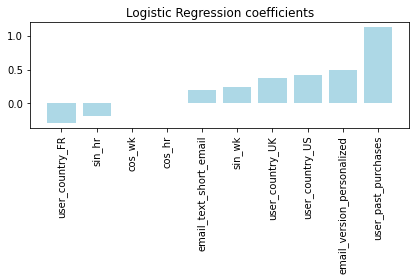

In [69]:
# Fit the model with optimal parameter using all the training data to evaluate feature importance.  
clf.fit(X_train, y_train)
lm_best_alpha=LogisticRegression(C= 0.01, #clf.best_params_['lmodel__C'], 
random_state=1)
pipe_lm_best = Pipeline([('minmax',MinMaxScaler()),  ('lmodel',lm_best_alpha )])
pipe_lm_best.fit(X_train,y_train)
feat_labels = X_train.columns
importances=lm_best_alpha.coef_
indices = np.argsort(importances)[::-1]
importances=importances[0]
plt.figure()
plt.title('Logistic Regression coefficients')
plt.bar(range(np.size(feat_labels)),importances[indices[0]],color='lightblue',align='center')
plt.xticks(range(np.size(feat_labels)),feat_labels[indices[0]], rotation=90)
plt.tight_layout()
plt.show()

In [71]:
lm_best_alpha

LogisticRegression(C=0.01, random_state=1)

In [70]:
coeff = pd.DataFrame(list(zip(X_train.columns, importances)))
coeff

,0,1
0,user_past_purchases,1.124427
1,email_text_short_email,0.204585
2,email_version_personalized,0.499781
3,user_country_FR,-0.289827
4,user_country_UK,0.373380
5,user_country_US,0.420596
6,sin_wk,0.241849
7,cos_wk,0.000000
8,sin_hr,-0.181520
9,cos_hr,0.000000


In [72]:
clf.best_estimator_

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lmodel', LogisticRegression(C=0.1, class_weight='balanced'))])

0.054 (+/-0.014) for {'lmodel__C': 0.001}
0.059 (+/-0.012) for {'lmodel__C': 0.01}
0.059 (+/-0.011) for {'lmodel__C': 0.1}
0.059 (+/-0.011) for {'lmodel__C': 1.0}
0.059 (+/-0.011) for {'lmodel__C': 10}
{'lmodel__C': 0.1}
Classification report
              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81     29364
         1.0       0.04      0.67      0.08       636

    accuracy                           0.68     30000
   macro avg       0.52      0.68      0.44     30000
weighted avg       0.97      0.68      0.79     30000

Test AUCPR = 0.03636269444835371


Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.04')

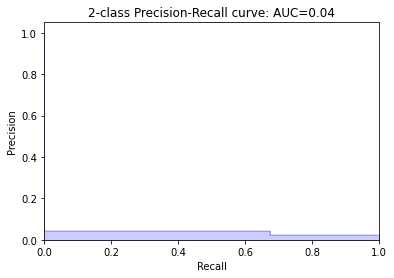

In [74]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(clf.best_params_)
clf.best_estimator_.fit(X_train,y_train)
pipe_lm_best = Pipeline([('minmax',MinMaxScaler()),  ('lmodel',lm_best_alpha )])
pipe_lm_best.fit(X_train,y_train)


y_pred=clf.best_estimator_.predict(X_test)
print('Classification report')
print(classification_report(y_test,y_pred))
print('Test AUCPR = ' + str(average_precision_score(y_test, y_pred)))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format( average_precision_score(y_test, y_pred)))

In [ ]:
# logisticRegressionCV doesn't support multiple metrics for scoring
#lrcv = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))),
   #                     cv=5, scoring=scoring, solver='liblinear', random_state=42)
#lrcv.fit(X_train, y_train)
